In [13]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder

In [14]:
#getting the dataset
dataset = pd.read_csv('windData.csv', header=0)
values = dataset.values
#encoding wind direction
encoder = LabelEncoder()
values[:, 2] = encoder.fit_transform(values[:,2])
#ensure all data is float
values = values.astype('float32')

In [15]:
#function to convert series to supervised
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [16]:
#data preprocessing by normalizing
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [18]:
#converting data to supervised
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[6, 7, 8, 9, 10]], axis=1, inplace=True)
reframed.columns = ['Temp', 'Dew', 'WindDir', 'Humidity', 'press', 'windSpeed', 'fwindSpeed'] 

In [19]:
len(reframed)

159024

In [20]:
#splitting, 3 years of training and 2 years for testing
#scaledpd = DataFrame(scaled)
#scaledpd.dropna(inplace = True)
values = reframed.values
n_train_hours = 120000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [21]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [22]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(120000, 1, 6) (120000,) (39024, 1, 6) (39024,)


In [23]:
# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.optimizers import SGD

In [33]:
model = Sequential()
model.add(LSTM(400, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(1))
model.add(Dense(1))
model.add(LeakyReLU(alpha=0.5))
optimizer = SGD(lr=0.00001, decay=0.001, momentum=0.9, nesterov=True)
model.compile(loss='mae', optimizer=optimizer)

In [34]:
# fit network
history = model.fit(train_X, train_y, epochs=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 120000 samples, validate on 39024 samples
Epoch 1/10
 - 61s - loss: 0.0082 - val_loss: 0.0080
Epoch 2/10
 - 56s - loss: 0.0079 - val_loss: 0.0077
Epoch 3/10
 - 51s - loss: 0.0078 - val_loss: 0.0076
Epoch 4/10
 - 52s - loss: 0.0077 - val_loss: 0.0075
Epoch 5/10
 - 52s - loss: 0.0077 - val_loss: 0.0075
Epoch 6/10
 - 62s - loss: 0.0077 - val_loss: 0.0074
Epoch 7/10
 - 55s - loss: 0.0076 - val_loss: 0.0074
Epoch 8/10
 - 51s - loss: 0.0076 - val_loss: 0.0074
Epoch 9/10
 - 50s - loss: 0.0076 - val_loss: 0.0074
Epoch 10/10
 - 49s - loss: 0.0076 - val_loss: 0.0074


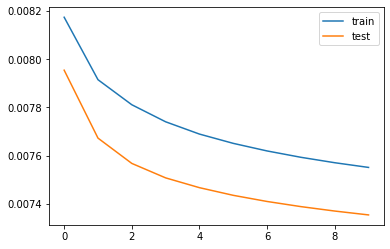

In [35]:
#plotting to check loss
from  matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [17]:
# invert scaling for forecast
from numpy import concatenate

In [18]:
inv_yhat = concatenate((test_X[:, :-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

In [19]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [20]:
#error
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#print('Individual RMSE: ')
#indrmse = [];
#for i in range(len(inv_y)):
 #   rms = sqrt(float(abs(inv_y[i]-inv_yhat[i])))
  #  indrmse.append(rms)
#pyplot.plot(indrmse)

Test RMSE: 4.770


In [21]:
inv_yhat[:20]

array([8.380935 , 9.421188 , 9.579167 , 9.222219 , 7.840252 , 8.737131 ,
       8.243929 , 8.077768 , 8.077768 , 7.778214 , 5.714253 , 5.6915154,
       5.6915154, 5.6915154, 5.6206236, 5.6206236, 5.6206236, 5.6206236,
       5.6206236, 7.6862407], dtype=float32)

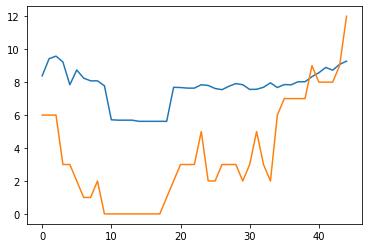

In [22]:
pyplot.plot(inv_yhat[:45], label='predicted')
pyplot.plot(inv_y[:45], label='test')
pyplot.show()